In [63]:
import numpy as np
import scipy as sp
import scipy.sparse as sps
import scipy.io as spio
import scipy.sparse.linalg as spsla
import trips.utilities.phantoms as phantom
import astra
from resizeimage import resizeimage
import matplotlib.pyplot as plt
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pylops
from trips.test_problems.Tomography import *

In [68]:
#!/usr/bin/env python
""" 
Builds a Tomography class
--------------------------------------------------------------------------
Created in January 2024 for TRIPs-Py library
"""
__authors__ = "Mirjeta Pasha, Silvia Gazzola, Connor Sanderford, and Ugochukwu Obinna Ugwu"
__affiliations__ = 'Tufts University, University of Bath, Arizona State University, and Tufts University'
__copyright__ = "Copyright 2024, TRIPs-Py library"
__license__ = "GPL"
__version__ = "1.0"
__email__ = "mirjeta.pasha@tufts.edu; mirjeta.pasha1@gmail.com; sg968@bath.ac.uk; csanderf@asu.edu; connorsanderford@gmail.com; Ugochukwu.Ugwu@tufts.edu"

# sys.path.insert(0,'/Users/mirjetapasha/Documents/Research_Projects/TRIPSpy/TRIPSpy')
import time
import numpy as np
import scipy as sp
import scipy.stats as sps
import scipy.io as spio
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import astra
import trips.utilities.phantoms as phantom
from venv import create
import pylops
from scipy.ndimage import convolve
from scipy import sparse
import scipy.special as spe
from trips.utilities.operators_old import *
from PIL import Image
from resizeimage import resizeimage
import requests
from os import mkdir
from os.path import exists
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve1d
from trips.utilities.utils import *
import scipy.linalg as la

class Tomography1():
    def __init__(self,**kwargs):
        seed = kwargs.pop('seed',2022)
        self.nx = None
        self.ny = None
        self.CommitCrime = kwargs['CommitCrime'] if ('CommitCrime' in kwargs) else False
        
    def define_proj_id(self, nx, ny, views, **kwargs):
        self.dataset = kwargs['dataset'] if ('dataset' in kwargs) else False
        self.nx = nx
        self.ny = ny
        self.p = int(np.sqrt(2)*self.nx)    # number of detector pixels
        self.q = views           # number of projection angles
        self.views = views
        self.theta = np.linspace(0, np.pi, self.q, endpoint=False)   # in rad
        self.source_origin = 3*self.nx                     # source origin distance [cm]
        self.detector_origin = self.nx                      # origin detector distance [cm]
        self.detector_pixel_size = (self.source_origin + self.detector_origin)/self.source_origin
        self.detector_length = self.detector_pixel_size*self.p   # detector length
        self.vol_geom = astra.create_vol_geom(self.nx,self.nx)
        if self. CommitCrime == False:
            self.theta_mis = self.theta + 1e-8
            self.proj_geom_mis = astra.create_proj_geom('fanflat', self.detector_pixel_size, self.p, self.theta_mis, self.source_origin, self.detector_origin)
            self.proj_id = astra.create_projector('line_fanflat', self.proj_geom_mis, self.vol_geom)
        else:
            self.proj_geom = astra.create_proj_geom('fanflat', self.detector_pixel_size, self.p, self.theta, self.source_origin, self.detector_origin)
            self.proj_id = astra.create_projector('line_fanflat', self.proj_geom, self.vol_geom)
        return self.proj_id

    def define_A(self, nx, ny, views): 
            proj_id = self.define_proj_id(nx, ny, views)  
            self.A = astra.OpTomo(self.proj_id)     
            return self.A

    def forward_Op(self, x, nx, ny, views):
        A = self.define_A(nx, ny, views)
        operatorf = lambda X: (A*X.reshape((nx, ny))).reshape(-1,1)
        operatorb = lambda B: A.T*B.reshape((self.p, self.q))
        OP = pylops.FunctionOperator(operatorf, operatorb, self.p*self.q, nx*ny)
        return OP, A

    def gen_true(self, test_problem, **kwargs):
        if (self.nx is None or self.ny is None):
            if (('nx' in kwargs) and ('ny' in kwargs)):
                self.nx = kwargs['nx'] 
                self.ny = kwargs['ny'] 
            else:
                raise TypeError("The dimension of the image is not specified. You can input nx and ny as (x_true, nx, ny) = Tomo.gen_true(testproblem, nx = nx, ny = ny) or first define the forward operator")
        
        if test_problem in ['SL60', 'SL90', 'head']:
            image = self.im_image_dat(test_problem)
            newimage = image
            current_shape = get_input_image_size(image)
            if ((current_shape[0] is not self.nx) and (current_shape[1] is not self.ny)):
                newimage = image_to_new_size(image, (self.nx, self.ny))
                newimage[np.isnan(newimage)] = 0
                x_truef = newimage
        elif test_problem in ['grains', 'smooth', 'tectonic', 'threephases', 'ppower']:
            if test_problem == 'grains':
                N_fine = self.nx
                numGrains = int(round(4*np.sqrt(N_fine)))
                x_true = phantom.grains(N_fine, numGrains) 
                tmp_shape = x_true.shape
                self.nx = tmp_shape[0]
                self.ny = tmp_shape[1]
                x_truef = x_true.reshape((-1,1)) 
            elif test_problem == 'smooth':
                N_fine = self.nx
                x_true = phantom.smooth(N_fine) 
                tmp_shape = x_true.shape
                self.nx = tmp_shape[0]
                self.ny = tmp_shape[1]
                x_truef = x_true.reshape((-1,1)) 
            elif test_problem == 'tectonic':
                N_fine = self.nx
                x_true = phantom.tectonic(N_fine)
                tmp_shape = x_true.shape
                self.nx = tmp_shape[0]
                self.ny = tmp_shape[1] 
                x_truef = x_true.reshape((-1,1)) 
            elif test_problem == 'threephases':
                N_fine = self.nx
                x_true = phantom.threephases(N_fine) 
                tmp_shape = x_true.shape
                self.nx = tmp_shape[0]
                self.ny = tmp_shape[1]
                x_truef = x_true.reshape((-1,1)) 
            elif test_problem == 'ppower':
                N_fine = self.nx
                x_true = phantom.ppower(N_fine) 
                tmp_shape = x_true.shape
                self.nx = tmp_shape[0]
                self.ny = tmp_shape[1]
                x_truef = x_true.reshape((-1,1)) 
        else:
            raise TypeError("You must enter a valid test problem! Options are: grains, smooth, tectonic, threephases, ppower, CT60, CT90, head.")
        
        return (x_truef, self.nx, self.ny)

    def gen_saved_data(self, dataset):
        if dataset == 60:
           test_problem = 'SL60'
           otherdata = 'CT60'
           data = self.im_other_dat(test_problem)
           CT = self.im_other_dat(otherdata)
           A, phi, s = CT['A'],CT['phi'],CT['s']
           x_true = data['x_true']
           b = data['b'].T#A*x_true.reshape((-1,1))
           self.q = phi.shape[1]
           self.p = s.shape[1]
        elif dataset == 90:
           test_problem = 'SL90'
           otherdata = 'CT90'
           data = self.im_other_dat(test_problem)
           CT = self.im_other_dat(otherdata)
           A, phi, s = CT['A'],CT['phi'],CT['s']
           x_true = data['x_true']
           b = data['x_true']['b'].T#A*x_true.reshape((-1,1))
           b = b[0][0]
           self.q = phi.shape[1]
           self.p = s.shape[1]
        elif dataset == 'head':
            test_problem = 'head'
            otherdata = 'CT200'
            data = self.im_other_dat(test_problem)
            CT = self.im_other_dat(otherdata)
            # CT = spio.loadmat('/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package/demos/data/CT/CT_x512_proj200_loc512.mat')
            A,phi,s = CT['A'],CT['phi'],CT['s']
            # data = spio.loadmat('/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package/demos/data/CT/'+'head'+'.mat')
            x_true, b = data['x_true'], data['x_true']['b']
            b = b.T
            b = b[0][0]
        return (A, x_true, b)

    def gen_data(self, x, nx, ny, views):
        self.nx = nx
        self.ny = ny
        self.views = views
        proj_id = self.define_proj_id(self.nx, self.ny, self.views)
        (A, AforMatrixOperation) = self.forward_Op(x, self.nx, self.ny, self.views)
        b = A@x.reshape((-1,1))
        bshape = b.shape
        self.p = self.views
        self.q = int(bshape[0]/self.views)
        bimage = b.reshape((self.p, self.q))
        return A, b, self.p, self.q, AforMatrixOperation
    
    def add_noise(self, b_true, opt, noise_level):
        if (opt == 'Gaussian'):
            # mu_obs = np.zeros((self.p*self.q,1))      # mean of noise
            noise = np.random.randn(b_true.shape[0]).reshape((-1,1))
            e = noise_level * np.linalg.norm(b_true) / np.linalg.norm(noise) * noise
            e = e.reshape((-1,1))
            b_true = b_true.reshape((-1,1))
            delta = la.norm(e)
            b = b_true + e # add noise
            b_meas = b_true + e
            b_meas_i = b_meas.reshape((self.p, self.q))
        elif (opt == 'Poisson'):
            # Add Poisson Noise 
            gamma = 1 # background counts assumed known
            b_meas = np.random.poisson(lam=b_true+gamma) 
            b_meas_i = b_meas.reshape((self.p, self.q))
            delta = 0
        else:
            mu_obs = np.zeros(self.p*self.q)      # mean of noise
            e = np.random.laplace(self.p*self.q)
            sig_obs = noise_level * np.linalg.norm(b_true)/np.linalg.norm(e)
            b_meas = b_true + sig_obs*e
            delta = la.norm(sig_obs*e)
            b_meas_i = b_meas.reshape((self.p, self.q))
        return (b_meas_i , delta)

    def plot_rec(self, img, save_imgs=True, save_path='./saveImagesTomo'):
            plt.set_cmap('inferno')
            if save_imgs and not os.path.exists(save_path): os.makedirs(save_path)
            plt.imshow(img.reshape((self.nx, self.ny)))
            plt.axis('off')
            if save_imgs:  plt.savefig(save_path+'/rec'+'.png',bbox_inches='tight')
            plt.pause(.1)
            plt.draw()

    def im_other_dat(self, im):
        if exists(f'./data/image_data/{im}.mat'):
            print('data already in the path.')
        else:
            print("Please make sure your data are on the data folder!")
        f = spio.loadmat(f'./data/image_data/{im}.mat')
        return f
    
    def im_image_dat(self, im):
        if exists(f'./data/image_data/{im}.mat'):
            print('data already in the path.')
        else:
            print("Please make sure your data are on the data folder!")
        f = spio.loadmat(f'./data/image_data/{im}.mat')
        X = f['x_true']
        im_shape = X.shape
        if len(im_shape) == 3:
             X = 0.4*X[:, :, 0] + 0.4*X[:, :, 1] + 0.1*X[:, :, 2]
        return X  
    
    def plot_data(self, img, save_imgs = False, save_path='./saveImagesData'):
        plt.set_cmap('inferno')
        if save_imgs and not os.path.exists(save_path): os.makedirs(save_path)
        plt.imshow(img.reshape((self.p, self.q)))
        plt.axis('off')
        if save_imgs:  plt.savefig(save_path+'/sino'+'.png',bbox_inches='tight')
        plt.pause(.1)
        plt.draw()

In [69]:
Tomo = Tomography1(CommitCrime = False)
# Specify the dimensions of the phantom and the number of angels that we call views
views = 90
nx = 64
ny = 64
# Step 1: Define the true solution throught the function gen_true(). 
# Options are: grains, smooth, tectonic, threephases, ppower
testproblem = 'head'
(x_true, nx, ny) = Tomo.gen_true(testproblem, nx = nx, ny = ny)
# Step 2: Define the forward operator
ATrue = Tomo.forward_Op(x_true, nx, ny, views)
# Generate the data: We can skip Step 1 and generate the sinogram and the operator by the following lines
(ATrue, b_trueTrue, pTrue, qTrue, AforMatrixOperationTrue) = Tomo.gen_data(x_true, nx, ny, views)
# Add noise in the true simulated sinogram b_true
# The opt defines the type of the noise. Options are Gaussian, Laplace, and Poisson
# The noise level defines the percentage of the noise added in the data. A value 0.01 means 1% additive noise
(bTrue, deltaTrue) = Tomo.add_noise(b_true = b_trueTrue, opt = 'Gaussian', noise_level = 0.001)
b_vecTrue = bTrue.reshape((-1,1))

data already in the path.


Exception: z shape is too small

In [70]:
(A, x_true, b) = Tomo.gen_saved_data(dataset = 'head')

data already in the path.
data already in the path.


In [73]:
x_true[0][0]

(array([[0.0625    , 0.109375  , 0.140625  , ..., 0.140625  , 0.109375  ,
        0.0625    ],
       [0.0625    , 0.11328125, 0.140625  , ..., 0.14257812, 0.11523438,
        0.0625    ],
       [0.06835938, 0.1015625 , 0.13867188, ..., 0.13867188, 0.1015625 ,
        0.07226562],
       ...,
       [0.        , 0.06054688, 0.11132812, ..., 0.83984375, 0.14453125,
        0.11328125],
       [0.        , 0.06835938, 0.1015625 , ..., 0.84960938, 0.13867188,
        0.1015625 ],
       [0.        , 0.0625    , 0.11328125, ..., 0.1640625 , 0.14257812,
        0.11523438]]), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16))

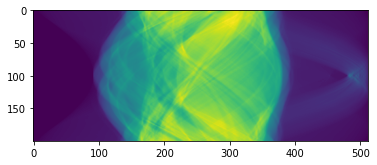

In [75]:
plt.imshow(x_true[0][0][0])

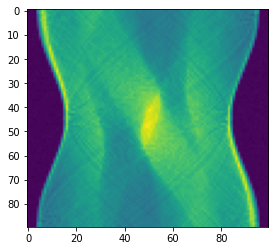

In [62]:
plt.imshow(b)

In [64]:
im = 'head'
f = spio.loadmat(f'./data/image_data/{im}.mat')
# X = f['x_true']
f['x_true']['b']

array([[array([[0.0625    , 0.109375  , 0.140625  , ..., 0.140625  , 0.109375  ,
                0.0625    ],
               [0.0625    , 0.11328125, 0.140625  , ..., 0.14257812, 0.11523438,
                0.0625    ],
               [0.06835938, 0.1015625 , 0.13867188, ..., 0.13867188, 0.1015625 ,
                0.07226562],
               ...,
               [0.        , 0.06054688, 0.11132812, ..., 0.83984375, 0.14453125,
                0.11328125],
               [0.        , 0.06835938, 0.1015625 , ..., 0.84960938, 0.13867188,
                0.1015625 ],
               [0.        , 0.0625    , 0.11328125, ..., 0.1640625 , 0.14257812,
                0.11523438]])                                                   ]],
      dtype=object)

In [10]:
dataname = 'head'
data = spio.loadmat('/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package/demos/data/CT/'+ dataname +'.mat')
data        

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Sun Apr 30 03:20:00 2023',
 '__version__': '1.0',
 '__globals__': [],
 'b': array([[0.0625    , 0.109375  , 0.140625  , ..., 0.140625  , 0.109375  ,
         0.0625    ],
        [0.0625    , 0.11328125, 0.140625  , ..., 0.14257812, 0.11523438,
         0.0625    ],
        [0.06835938, 0.1015625 , 0.13867188, ..., 0.13867188, 0.1015625 ,
         0.07226562],
        ...,
        [0.        , 0.06054688, 0.11132812, ..., 0.83984375, 0.14453125,
         0.11328125],
        [0.        , 0.06835938, 0.1015625 , ..., 0.84960938, 0.13867188,
         0.1015625 ],
        [0.        , 0.0625    , 0.11328125, ..., 0.1640625 , 0.14257812,
         0.11523438]]),
 'x_true': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)}

In [6]:
from trips.utilities.helpers import *
# Running the function convert_image_for_trips(imag = 'name_of_the_image', image_type = 'type_of_th_image)
# will save your data as name_of_the_image.mat that can be used from the other functionalities
convert_image_for_trips(imag = 'head', image_type= 'mat')

In [13]:
Tomo = Tomography1(CommitCrime = False)
# Specify the dimensions of the phantom and the number of angels that we call views
views = 90
nx = 64
ny = 64
# Step 1: Define the true solution throught the function gen_true(). 
# Options are: grains, smooth, tectonic, threephases, ppower
testproblem = 'tectonic'
(x_true, nx, ny) = Tomo.gen_true(nx, ny, testproblem)
# Step 2: Define the forward operator
A = Tomo.forward_Op(x_true, nx, ny, views)
# Generate the data: We can skip Step 1 and generate the sinogram and the operator by the following lines
(A, b_true, p, q, AforMatrixOperation) = Tomo.gen_data(x_true, nx, ny, views)
# Add noise in the true simulated sinogram b_true
# The opt defines the type of the noise. Options are Gaussian, Laplace, and Poisson
# The noise level defines the percentage of the noise added in the data. A value 0.01 means 1% additive noise
(b, delta) = Tomo.add_noise(b_true = b_true, opt = 'Gaussian', noise_level = 0.001)
b_vec = b.reshape((-1,1))


In [14]:
tt = A-ATrue

In [15]:
np.linalg.norm(b_vec- b_vecTrue)/np.linalg.norm(b_vec)

0.0014110992445567829

In [16]:
np.linalg.norm(tt.todense(), 'fro')

0.011672017

In [18]:
from trips.utilities.operators import *
L = gen_first_derivative_operator_2D(nx, ny)
data_vec = b.reshape((-1,1))
from trips.solvers.GKS import *
(x_gks, info) = GKS(A, data_vec, L, projection_dim=3, n_iter=3, regparam = 0.1, x_true=x_true.reshape(-1,1))

running GKS...: 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]


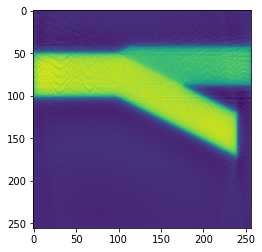

In [20]:
plt.imshow(x_gks.reshape((nx,ny)))

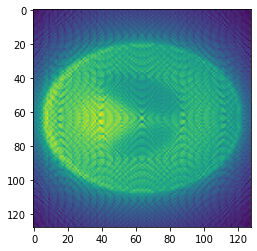

In [9]:
plt.imshow(b_true)
x_naive = A.T*b_true.reshape((-1,1))
plt.imshow(x_naive.reshape((128, 128)))

In [27]:
from trips.operators import *
L = spatial_derivative_operator(128, 128, 1)
data_vec = b_true.reshape((-1,1))
from trips.solvers.gks_all import *
(x_gks, info) = GKS(A, data_vec, L, projection_dim=3, n_iter=3, regparam = 0.1, x_true=x_true.reshape(-1,1))

ValueError: could not broadcast input array from shape (9000,) into shape (102400,)

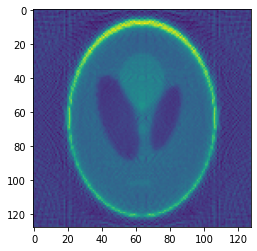

In [16]:
plt.imshow(x_gks.reshape((128,128)))

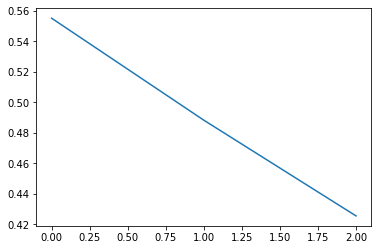

In [19]:
r_err = info['relError']
plt.plot(r_err)

In [7]:
CT = spio.loadmat('/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package/demos/data/CT/CT_x512_proj200_loc512.mat')
# CT_name = 'CT_x512_proj200_loc512'
dat_name = 'head'
# CT = spio.loadmat('./'+CT_name+'.mat')
A,phi,s = CT['A'],CT['phi'],CT['s']
data = spio.loadmat('/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package/demos/data/CT/'+dat_name+'.mat')
x_true,b = data['x_true'], data['b']
b = b.T

In [8]:
from trips.solvers.golub_kahan_tikhonov import *

In [9]:
x, lambd = golub_kahan_tikhonov(A, b.reshape((-1,1)), n_iter=15, regparam='gcv')

generating basis...:   0%|          | 0/3 [00:00<?, ?it/s]

generating basis...: 100%|██████████| 3/3 [00:00<00:00,  3.76it/s]


In [1]:
from trips.operators import *
L = spatial_derivative_operator(512, 512, 1)
data_vec = b.reshape((-1,1))
from trips.solvers.gks_all import *
(x_gks, info) = GKS(A, data_vec, L, projection_dim=3, n_iter=3, regparam = 0.001, x_true=x_true.reshape(-1,1))

NameError: name 'b' is not defined

(-0.5, 511.5, 511.5, -0.5)

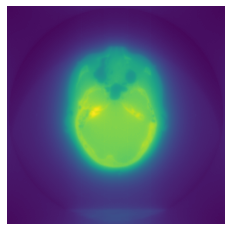

In [62]:
x = x.reshape((512, 512)).T
# x = x.T
plt.imshow(x)
plt.axis('off')

In [42]:
b = b.T
x_n = A.T*b.reshape((-1,1))

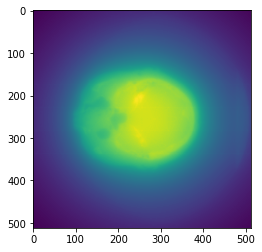

In [43]:
plt.imshow(x_n.reshape((512,512)))

In [12]:
# from trips.operators import *
# L = spatial_derivative_operator(512, 512, 1)
# data_vec = b.reshape((-1,1))
# from trips.solvers.gks_all import *
# (x_gks, info) = GKS(A, data_vec, L, projection_dim=1, n_iter=3, regparam = 'gcv', x_true=None)

In [13]:
plt.imshow(x_gks.reshape((512, 512)))

NameError: name 'x_gks' is not defined

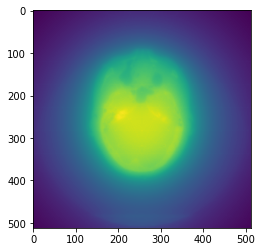

In [ ]:
x_naive = A.T*bnew.reshape((-1,1))
plt.imshow(x_naive.reshape((512,512)))

In [19]:
CT = spio.loadmat('/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package/demos/data/CT/CT_x128_proj60_loc100.mat')
A, phi, s = CT['A'],CT['phi'],CT['s']
data = spio.loadmat('/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package/demos/data/CT/Shepp-Logan_proj60_SNR100.mat')
x_true = data['x_true']
b = A*x_true.reshape((-1,1))

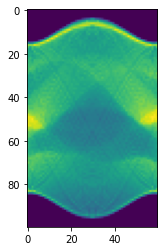

In [22]:
plt.imshow(b.reshape((100,60)))

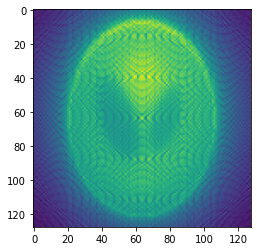

In [24]:
x_n = A.T*b
plt.imshow((x_n.reshape((128,128))))

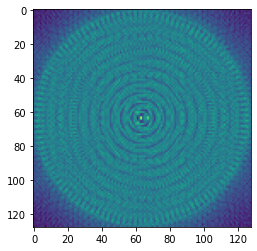

running GKS...:   0%|          | 0/3 [00:00<?, ?it/s]

running GKS...: 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]


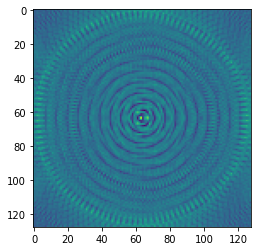

In [15]:
plt.imshow(x_gks[0].reshape((128,128)))

(-0.5, 127.5, 127.5, -0.5)

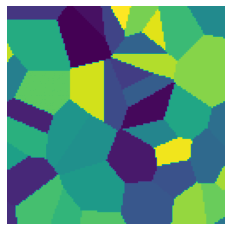

In [16]:
xtrue = Tomo.generate_true(test_problem = 'grains', sizex = sizex, sizey = sizey)
plt.imshow(xtrue.reshape((sizex, sizey)))
plt.axis('off')

In [17]:
b = Tomo.generate_data(x = xtrue, matrix = False)
plt.imshow(b.reshape((60, 100)))
Tomo.plot_data(b)

AttributeError: 'Tomography' object has no attribute 'sizex'

In [27]:
(b_noise, delta) = Tomo.add_noise(b, opt = 'Gaussian', noise_level = 0.01)

In [28]:
np.linalg.norm(delta)

27.46125712558026

In [29]:
from trips.solvers.gks_all import *
(x, info) = GKS(A, b_noise, D, projection_dim = 2, n_iter = 40, regparam='gcv', x_true=x_true)

NameError: name 'A' is not defined

In [25]:
class Tomograph:
    def __init__(self,**kwargs):
        seed = kwargs.pop('seed',2022)
    def set_up(self, sizex, sizey, views, **kwargs):
        self.dataset = kwargs['dataset'] if ('dataset' in kwargs) else False
        self.nx = sizex
        self.ny = sizey
        self.views = views
        self.angles = numpy.linspace(0, numpy.pi, views, endpoint = False)
        self.slice_geom = astra.create_vol_geom(pixels, pixels)
        self.slice_id = astra.data2d.create('-vol', slice_geom, phantom)
        self.sino_geom = astra.create_proj_geom('parallel', 1, pixels, angles)
        self.sino_id = astra.data2d.create('-sino', sino_geom)
        self.proj_id = astra.creators.create_projector('linear', sino_geom, slice_geom)
        return self.proj_id

    def forward_Op_mat(self, sizex, sizey, views):
        proj_geom, proj_id = self.set_up(sizex, sizey, views)
        self.mat_id = astra.projector.matrix(proj_id)
        return astra.matrix.get(self.mat_id) 

    def forward_Op(self, sizex, sizey): 
        proj_geom, proj_id = self.set_up(sizex, sizey)       
        return astra.OpTomo(self.proj_id)

    def generate_true(self, test_problem):
        if test_problem == 'grains':
            N_fine = self.nx
            numGrains = int(round(4*np.sqrt(N_fine)))
            x_true = phantom.grains(N_fine, numGrains) 
            x_truef = x_true.flatten(order='F') 
        elif test_problem == 'smooth':
            N_fine = self.nx
            x_true = phantom.smooth(N_fine) 
            x_truef = x_true.flatten(order='F') 
        elif test_problem == 'tectonic':
            N_fine = self.nx
            x_true = phantom.tectonic(N_fine) 
            x_truef = x_true.flatten(order='F') 
        elif test_problem == 'threephases':
            N_fine = self.nx
            x_true = phantom.threephases(N_fine) 
            x_truef = x_true.flatten(order='F') 
        elif test_problem == 'ppower':
            N_fine = self.nx
            x_true = phantom.ppower(N_fine) 
            x_truef = x_true.flatten(order='F') 
        elif test_problem == 'CT60':
            self.nx = 128
            self.ny = 128
            data = spio.loadmat('/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package/demos/data/CT/Shepp-Logan_proj60_SNR100.mat')
            x_true = data['x_true']
            x_truef = x_true.flatten(order='F') 
        elif test_problem == 'CT90':
            self.nx = 128
            self.ny = 128
            data = spio.loadmat('/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package/demos/data/CT/Shepp-Logan_proj90_SNR100.mat')
            x_true = data['x_true']
            x_truef = x_true.flatten(order='F') 
        return x_truef
    def generate_data(self, x, proj_type, flag, dataset):
        if flag == 'given_operator':
            if dataset == 60:
                CT = spio.loadmat('/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package/demos/data/CT/CT_x128_proj60_loc100.mat')
                A, phi, s = CT['A'],CT['phi'],CT['s']
                data = spio.loadmat('/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package/demos/data/CT/Shepp-Logan_proj60_SNR100.mat')
                b_true = data['b']
                out = b_true.flatten()
                self.q = phi.shape[1]
                self.p = s.shape[1]
            elif dataset == 90:
                CT = spio.loadmat('/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package/demos/data/CT/CT_x128_proj90_loc100.mat')
                A, phi, s = CT['A'],CT['phi'],CT['s']
                data = spio.loadmat('/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package/demos/data/CT/Shepp-Logan_proj60_SNR100.mat')
                b_true = data['b']
                out = b_true.flatten()
                self.q = phi.shape[1]
                self.p = s.shape[1]
        elif flag =='no_given_operator':
            if proj_type == 1:
                # forward projection
                _, b = astra.create_sino(x.reshape((self.nx,self.nx), order='F'), self.proj_id)
                b = np.fliplr(b)
                out = b.flatten()
            elif proj_type == 2:
                # backward projection   
                b = np.fliplr(x.reshape((self.q, self.p)))
                _, ATb = astra.create_backprojection(b, self.proj_id)
                b = ATb.flatten(order='F')
        else: ##MP: Will develop the true data case here
            if proj_type == 1:
                # performs the forward projection
                _, Ax = astra.create_sino(x.reshape((self.nx,self.nx), order='F'), self.proj_id)
                Ax = np.fliplr(Ax)
                out = Ax.flatten()
            elif proj_type == 2:
                # performs the backward projection   
                b = np.fliplr(x.reshape((self.q, self.p)))
                _, ATb = astra.create_backprojection(b, self.proj_id)
                b = ATb.flatten(order='F')
        return out
    def add_noise(self, b_true, opt, noise_level):
        if (opt == 'Gaussian'):
            # mu_obs = np.zeros((self.p*self.q,1))      # mean of noise
            noise = np.random.randn(b_true.shape[0]).reshape(-1,1)
            e = noise_level * np.linalg.norm(b_true) / np.linalg.norm(noise) * noise
            e = e.reshape(-1,1)
            b_true = b_true.reshape(-1,1)
            b = b_true + e # add noise
            b_meas = b_true + e
            b_meas_i = b_meas.reshape((self.p, self.q), order='F')
        elif (opt == 'Poisson'):
            # Add Poisson Noise 
            gamma = 1 # background counts assumed known
            b_meas = np.random.poisson(lam=b_true+gamma) 
            b_meas_i = b_meas.reshape((self.p, self.q), order='F')
        else:
            mu_obs = np.zeros(self.p*self.q)      # mean of noise
            e = np.random.laplace(self.p*self.q)
            sig_obs = noise_level * np.linalg.norm(b_true)/np.linalg.norm(e)
            b_meas = b_true + sig_obs*e
            b_meas_i = b_meas.reshape((self.p, self.q), order='F')
        return (b_meas_i , e)

    def plot_rec(self, img, save_imgs=True, save_path='./saveImagesTomo'):
            plt.set_cmap('inferno')
            if save_imgs and not os.path.exists(save_path): os.makedirs(save_path)
            plt.imshow(img.reshape((self.nx, self.ny), order = 'F'))
            plt.axis('off')
            if save_imgs:  plt.savefig(save_path+'/rec'+'.png',bbox_inches='tight')
            plt.pause(.1)
            plt.draw()
        
    def plot_data(self, img, save_imgs = False, save_path='./saveImagesData'):
        plt.set_cmap('inferno')
        if save_imgs and not os.path.exists(save_path): os.makedirs(save_path)
        plt.imshow(img.reshape((self.p, self.q), order = 'F'))
        plt.axis('off')
        if save_imgs:  plt.savefig(save_path+'/sino'+'.png',bbox_inches='tight')
        plt.pause(.1)
        plt.draw()

In [26]:
sizex = 250
sizey = 250
views = 60
TT = Tomograph(sizex = sizex, sizey = sizey, views = views)

In [27]:
TT.generate_true(test_problem = 'grains')

AttributeError: 'Tomograph' object has no attribute 'nx'